In [1]:
from transformers import BertTokenizer, BertForMaskedLM
import torch


/opt/homebrew/Caskroom/miniconda/base/envs/cvs-classifier/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Carica il tokenizer di BERT e il modello preaddestrato
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
# Esempio di testo con un token mascherato
text = "[MASK] capital [MASK] France is [MASK]"

In [4]:
# Tokenizza il testo e converte in tensori
tokens = tokenizer(text, return_tensors='pt')

### eda sui token


In [5]:
for list in tokens['input_ids'].tolist():
    for t in list:
        print(t)
        print(tokenizer.decode(t))
        print('\n')

101
[ C L S ]


103
[ M A S K ]


3007
c a p i t a l


103
[ M A S K ]


2605
f r a n c e


2003
i s


103
[ M A S K ]


102
[ S E P ]




In [6]:
# Calcola la maschera di attenzione
attention_mask = tokens['attention_mask']

# Applica la maschera di attenzione a un token specifico (ad esempio, il token [MASK])
masked_index = torch.where(tokens['input_ids'] == tokenizer.mask_token_id)[1]  # Ottieni solo gli indici di colonna
attention_mask[:, masked_index] = 0  # Imposta a 0 l'attenzione per i token mascherati


In [7]:
# Esegui l'output del modello
outputs = model(input_ids=tokens['input_ids'], attention_mask=attention_mask)

### eda 

In [8]:

print('tokens are: {} \n'.format(tokens))
print('attention_mask is : {} \n'.format(attention_mask))
print('masked_index is : {} \n'.format(masked_index))
#print("Esegui l'output del modello : {}".format(outputs))

tokens are: {'input_ids': tensor([[ 101,  103, 3007,  103, 2605, 2003,  103,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 0, 1, 0, 1, 1, 0, 1]])} 

attention_mask is : tensor([[1, 0, 1, 0, 1, 1, 0, 1]]) 

masked_index is : tensor([1, 3, 6]) 



In [9]:
# Recupera i logits per il token mascherato
logits = outputs.logits

# Recupera le probabilità previste dal modello
masked_token_probs = torch.softmax(logits[0, masked_index], dim=-1)

# Recupera l'ID del token previsto con la probabilità massima
predicted_token_ids = torch.argmax(masked_token_probs, dim=-1)

# Converti l'ID del token previsto in forma testuale
predicted_tokens = [tokenizer.decode([predicted_token_id.item()]) for predicted_token_id in predicted_token_ids]

print("Parola prevista:", predicted_tokens)


Parola prevista: ['the', 'of', '.']


----


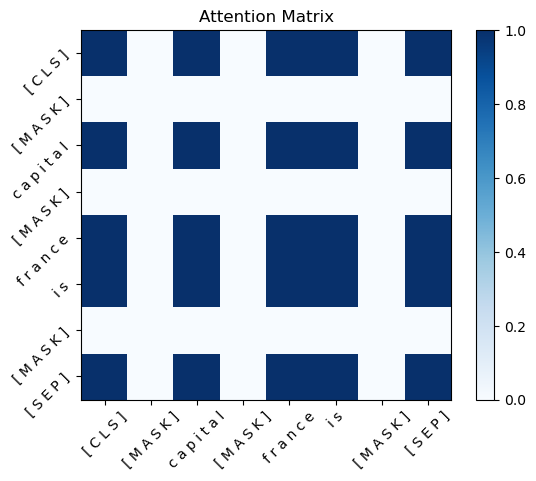

In [12]:
######## plot attention matrix ##########
import matplotlib.pyplot as plt

# Testo e maschera di attenzione
text = "[MASK] capital [MASK] France is [MASK]"
attention_mask = torch.tensor([[1, 0, 1, 0, 1, 1, 0, 1]])

# Indici dei token mascherati
masked_index = torch.tensor([1, 3, 6])

# Tokenizza il testo per ottenere il numero di token
#tokens = tokenizer.tokenize(text)
tokens_len =[]
decoded_tokens=[]
for list in tokens['input_ids'].tolist():
    for t in list:
        tokens_len.append(t)
        decoded_tokens.append(tokenizer.decode(t))

# Creazione dell'attention matrix
attention_matrix = torch.zeros((len(tokens_len), len(tokens_len)))

for i, token_i in enumerate(tokens_len):
    for j, token_j in enumerate(tokens_len):
        # Imposta l'attenzione a 0 se uno dei token è mascherato o se ci sono token duplicati
        if i in masked_index or j in masked_index:# i == j:
            attention_matrix[i, j] = 0
        else:
            attention_matrix[i, j] = attention_mask[0, min(i, j)]

# Visualizzazione dell'attention matrix

plt.imshow(attention_matrix, cmap='Blues', interpolation='nearest')
plt.title('Attention Matrix')
plt.xticks(range(len(decoded_tokens)), decoded_tokens, rotation=45)
plt.yticks(range(len(decoded_tokens)), decoded_tokens, rotation=45)
plt.colorbar()
plt.show()